In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from itertools import chain
from sys import platform
from copy import deepcopy as dc

vims_wave = np.loadtxt('vims_wave.txt')

new_array = ['_0405','_0607','_0809','_1011','_1213','_1415','_1617']
if platform == 'darwin' or platform == 'win32':
    for number in new_array:
        new_string = 'df'+number+' = pd.read_pickle("c_data/data'+number+'.pkl")'
        exec(new_string)
else:
    df_list = []
    for number in new_array:
        new_string = 'df'+number+' = pd.read_csv("c_data/data'+number+'.csv")'
        exec(new_string)
        df = 'df'+number
        new_df = locals()[df]
        df_list.append(new_df)
    for df in df_list:
        for i in range(len(df['spectrum'])):
            df['spectrum'][i] = np.array([float(x) for x in df['spectrum'][i][1:-1].split(',')])

def powerlaw(x,a,b):
    return a*np.power(x,b)

def gaussian(x,a,mu,sigma):
    return a*np.exp(-(x-mu)**2/(2*sigma**2))

def flatten(some_list):
    flat_list = []
    for element in some_list:
        if type(element) is list:
            for item in element:
                flat_list.append(item)
        else:
            flat_list.append(element)
    return flat_list

band_channels = list(chain(range(29,35),range(46,60),range(78,96),range(102,106)))

window = list(range(56,83))

def fit_line(dataframe):
    spectra = np.average(dataframe)
    my_fit,_ = curve_fit(powerlaw,vims_wave[band_channels],spectra[band_channels],p0=[.15,-12])
    final_fit = powerlaw(vims_wave,*my_fit)
    return final_fit

def custom_fit(dataframe):
    spectra = np.average(dataframe)
    my_fit,_ = curve_fit(powerlaw,vims_wave[band_channels],spectra[band_channels],p0=[.15,-12])
    final_spectra = spectra-powerlaw(vims_wave,*my_fit)
    return final_spectra

def single_fit(spectrum):
    my_fit,_ = curve_fit(powerlaw,vims_wave[band_channels],spectrum[band_channels],p0=[.15,-12])
    final_spectrum = spectrum-powerlaw(vims_wave,*my_fit)

def shift_ret(spectrum):
    my_fit,_ = curve_fit(gaussian,vims_wave[window],spectrum[window],p0=[.05,2.05])
    return my_fit[1]

In [2]:
scatter_list = []
for number in new_array:
    my_string = 'scatter'+number+" = df"+number
    exec(my_string)
    scatter = 'scatter'+number
    scatter_list.append(locals()[scatter])

total_scatter = pd.concat(scatter_list)

spec_list = []
for number in new_array:
    my_string = 'old_spec'+number+' = df'+number+"['spectrum']"
    exec(my_string)
    new_string = 'spec'+number+' = np.array([np.abs(x) for x in old_spec'+number+'])'
    exec(new_string)
    spec = 'spec'+number
    spec_list.append(locals()[spec])

copy_list = []
for number in new_array:
    my_string = 'copy_spec'+number+' = dc(spec'+number+')'
    exec(my_string)
    copy_spec = 'copy_spec'+number
    copy_list.append(locals()[copy_spec])

In [3]:
for (spec,copy_spec,j) in zip(spec_list,copy_list,range(7)):
    bool_list = []
    mean_list = []
    for i in range(256):
        mean = np.mean(spec[:,i])
        median = np.median(spec[:,i])
        vals = copy_spec[:,i]
        std = np.std(spec[:,i])
        ind = np.where(np.abs(vals-mean)>3*std)
        vals[ind] = median
        new_mean = np.mean(copy_spec[:,i])

        bool_list.append([])
        if np.abs(new_mean-mean)>.05*mean:
            bool_list[i].append(False)
            bool_list[i].append(0)
        else:
            bool_list[i].append(True)
            bool_list[i].append(0)
        
        my_string = 'mean_list_'+str(i)+' = []'
        exec(my_string)
        mean_list.append(locals()['mean_list_'+str(i)])
        mean_list[i].append(new_mean)
    
    #While loop filtering
    for i in range(256):
        statement = bool_list[i][0]
        counter = bool_list[i][1]
        while statement == False:
            if counter == 0:
                old_mean = mean_list[i][0]
                new_mean = np.mean(copy_spec[:,i])
            else:
                old_mean = mean_list[i][counter]
                new_mean = np.mean(copy_spec[:,i])
            std = np.std(copy_spec[:,i])
            median = np.median(copy_spec[:,i])
            vals = copy_spec[:,i]
            ind = np.where(np.abs(vals-mean)>3*std)
            if np.abs(new_mean-old_mean)>.05*old_mean:
                vals[ind] = median
                counter += 1
            else:
                vals[ind] = median
                statement = True   

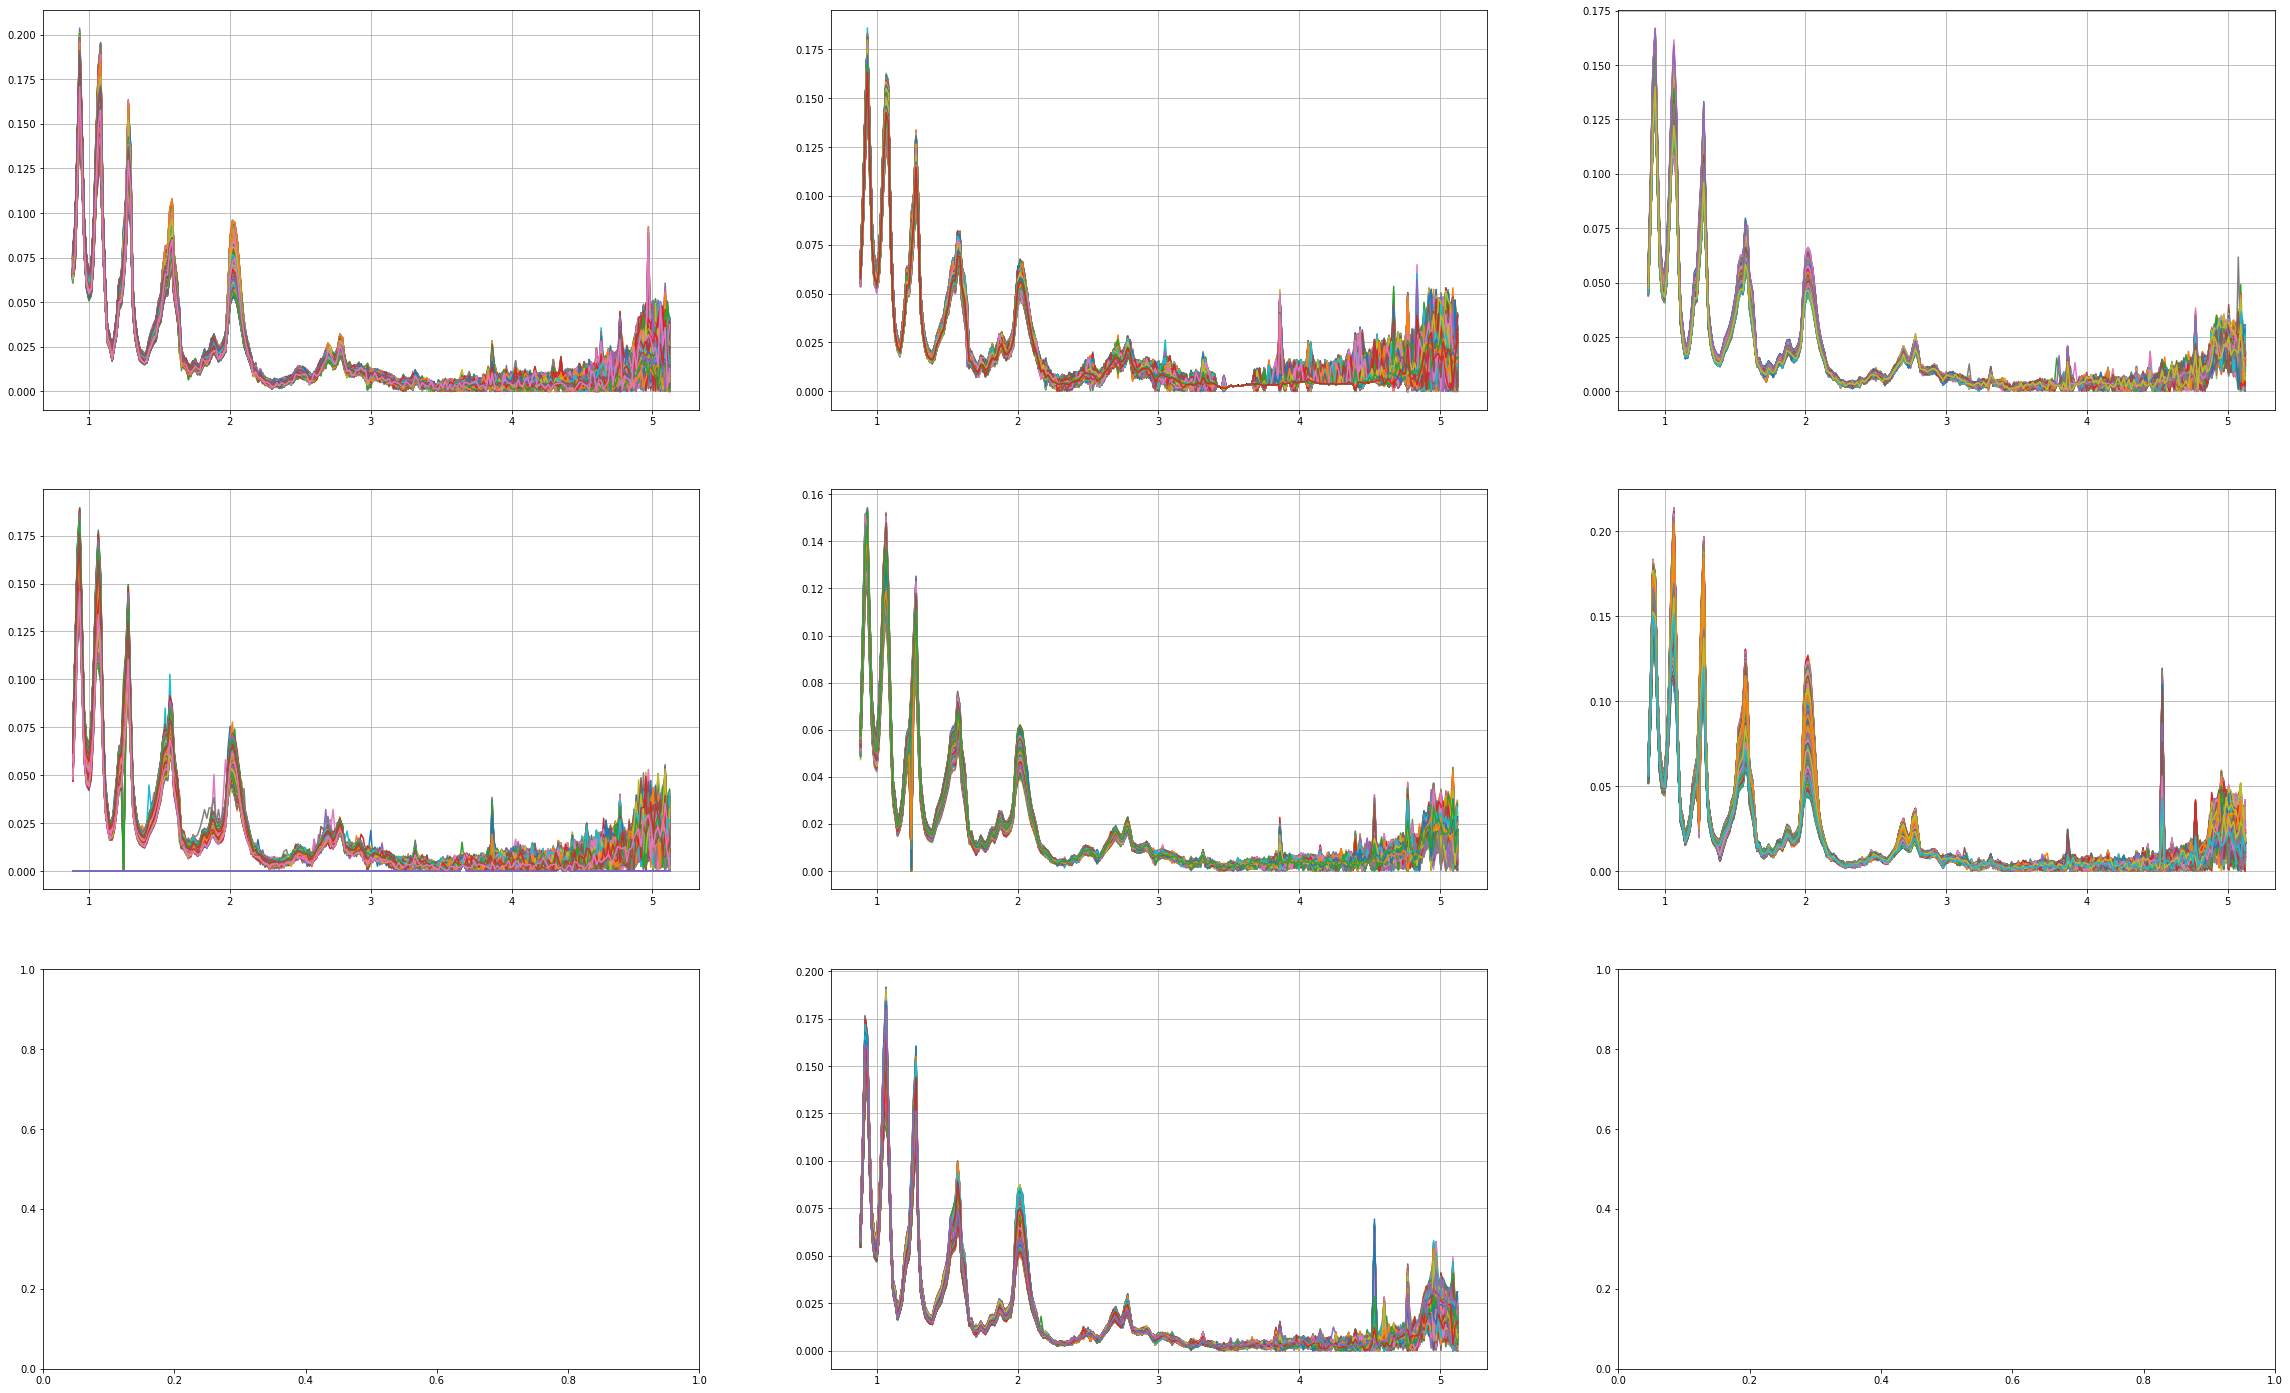

In [4]:
%matplotlib inline
fig,axs = plt.subplots(3,3,figsize=(40,25),facecolor='white')
for index,spec in enumerate(copy_list):
    for spectrum in spec:
        if index < 3:
            axs[0,index].plot(vims_wave,spectrum)
        if index < 6 and index >= 3:
            axs[1,index-3].plot(vims_wave,spectrum)
        if index >= 6:
            axs[2,index-5].plot(vims_wave,spectrum)
    if index < 3:
        axs[0,index].grid()
    if index < 6 and index >= 3:
        axs[1,index-3].grid()
    if index >= 6:
        axs[2,index-5].grid()

plt.show()